# Compling the cross-validation datasets

[Prev](./240706-1-complie-main.ipynb): Compile the main dataset

Preprocessing:
- OGs: filter out "rare" orthologs to let Markov-modulation focus on the global evolutionary trends
- tree: branch length adjustment (using MP)

In [1]:
import gzip, json

import numpy as np
import pandas as pd
from ete3 import Tree

from colaml import *
from colaml.misc.dataplot import draw_extant
from colaml.misc.parsimony import mean_mp_changes
from myconfig import DATASET_DIR

In [2]:
from threadpoolctl import threadpool_limits
threadpool_limits(1, user_api='blas')

In [3]:
with gzip.open(DATASET_DIR/'03-fish'/'fish-main-v0.json.gz') as file:
    data = json.load(file)

In [4]:
# Define an otholog as "rare" if only 5% or less of species have it.
rawOGs = pd.DataFrame(**data['OGs'])
filtOGs = rawOGs.loc[:, rawOGs.ne(0).sum(axis=0) > len(rawOGs) * 0.05]
filtOGs

,100038at7898,100039at7898,100063at7898,100080at7898,100097at7898,100102at7898,100157at7898,100179at7898,100191at7898,100208at7898,...,99839at7898,99844at7898,99883at7898,99886at7898,99903at7898,99947at7898,99951at7898,99972at7898,99985at7898,99986at7898
Erpetoichthys_calabaricus,2,1,1,1,0,0,1,0,0,0,...,1,1,0,0,0,0,1,1,0,1
Polypterus_senegalus,2,1,1,2,0,0,1,0,0,0,...,1,1,0,0,0,0,1,1,0,0
Acipenser_ruthenus,4,4,2,0,0,1,2,0,0,0,...,2,2,0,0,0,0,2,1,0,2
Polyodon_spathula,3,2,2,0,2,0,2,0,0,0,...,2,2,0,0,0,0,1,2,0,2
Lepisosteus_oculatus,2,0,1,1,1,0,1,0,1,0,...,1,1,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Poecilia_reticulata,2,1,1,1,1,4,1,1,0,1,...,1,1,1,1,1,0,1,2,1,1
Gambusia_affinis,2,1,1,1,6,3,1,1,0,1,...,1,1,1,1,1,0,1,2,1,1
Xiphophorus_hellerii,2,1,1,1,0,5,1,1,1,1,...,1,1,1,1,1,0,2,2,1,1
Xiphophorus_maculatus,2,1,1,1,0,2,1,1,0,1,...,1,1,1,1,0,0,1,2,1,1


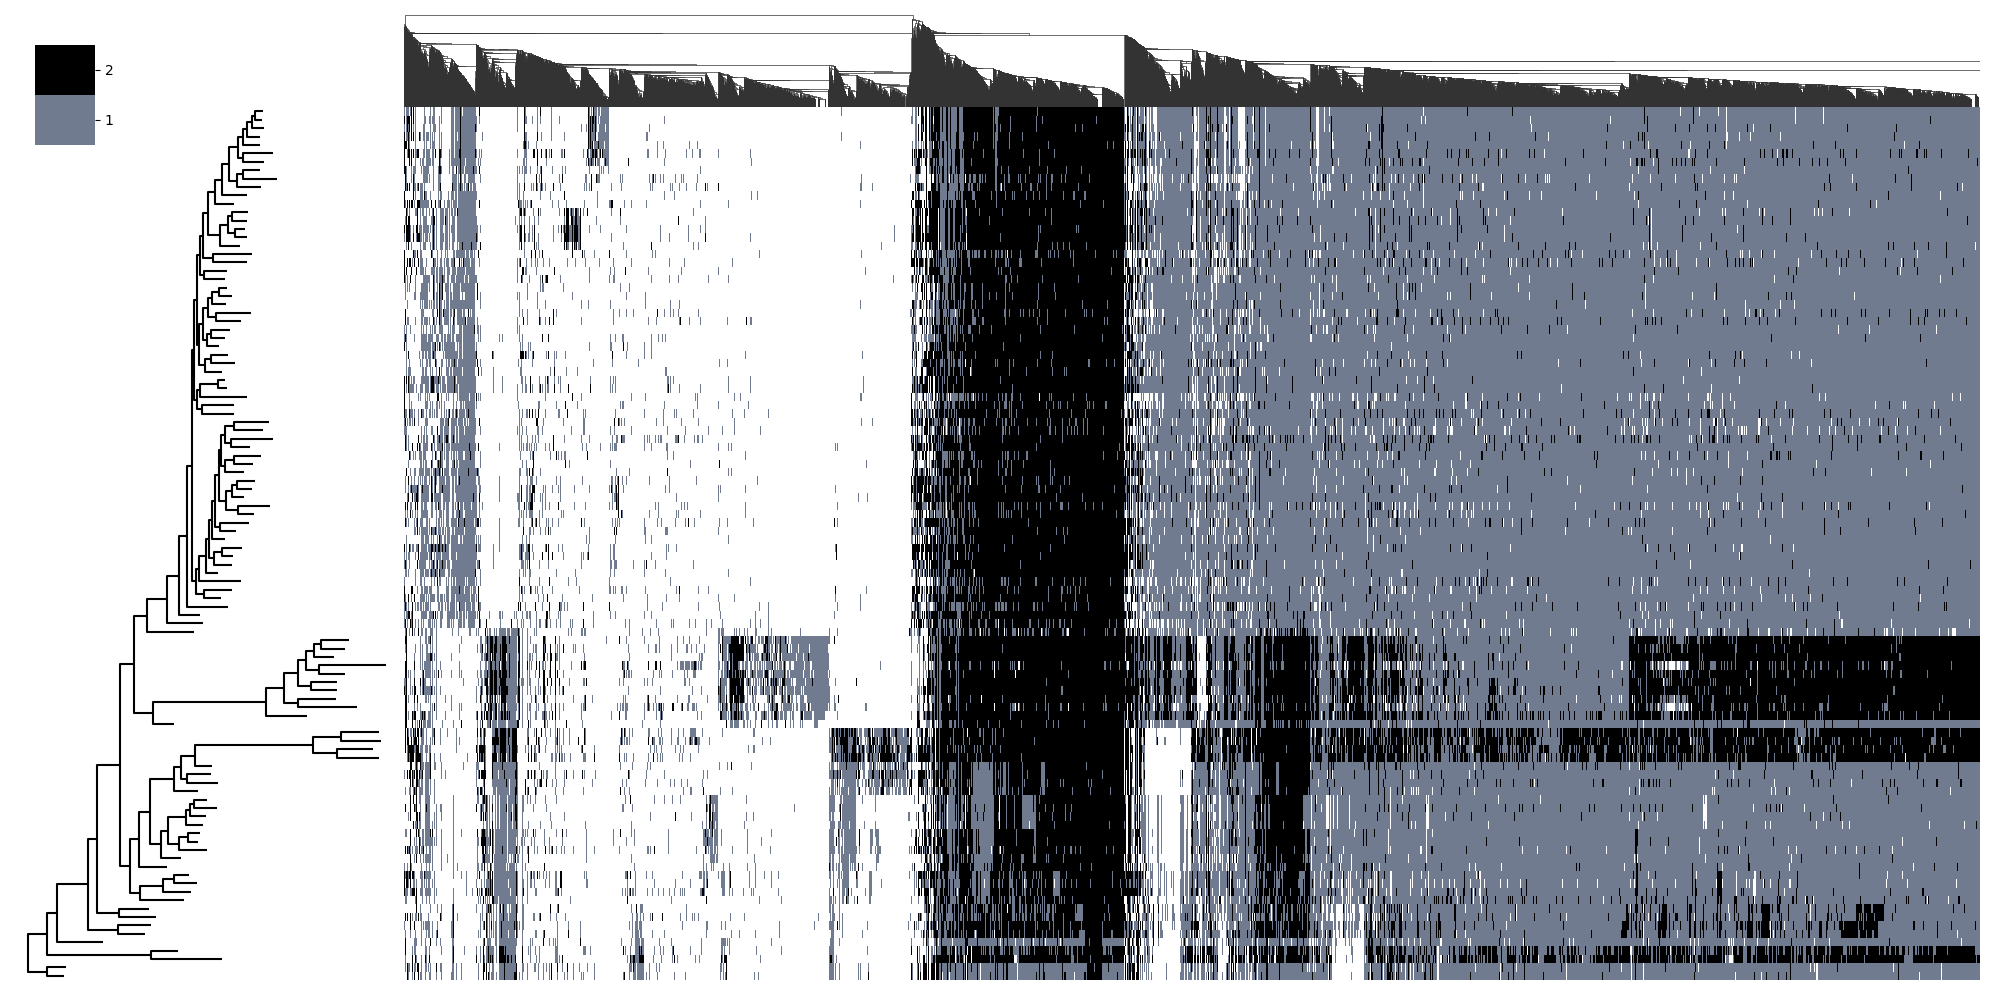

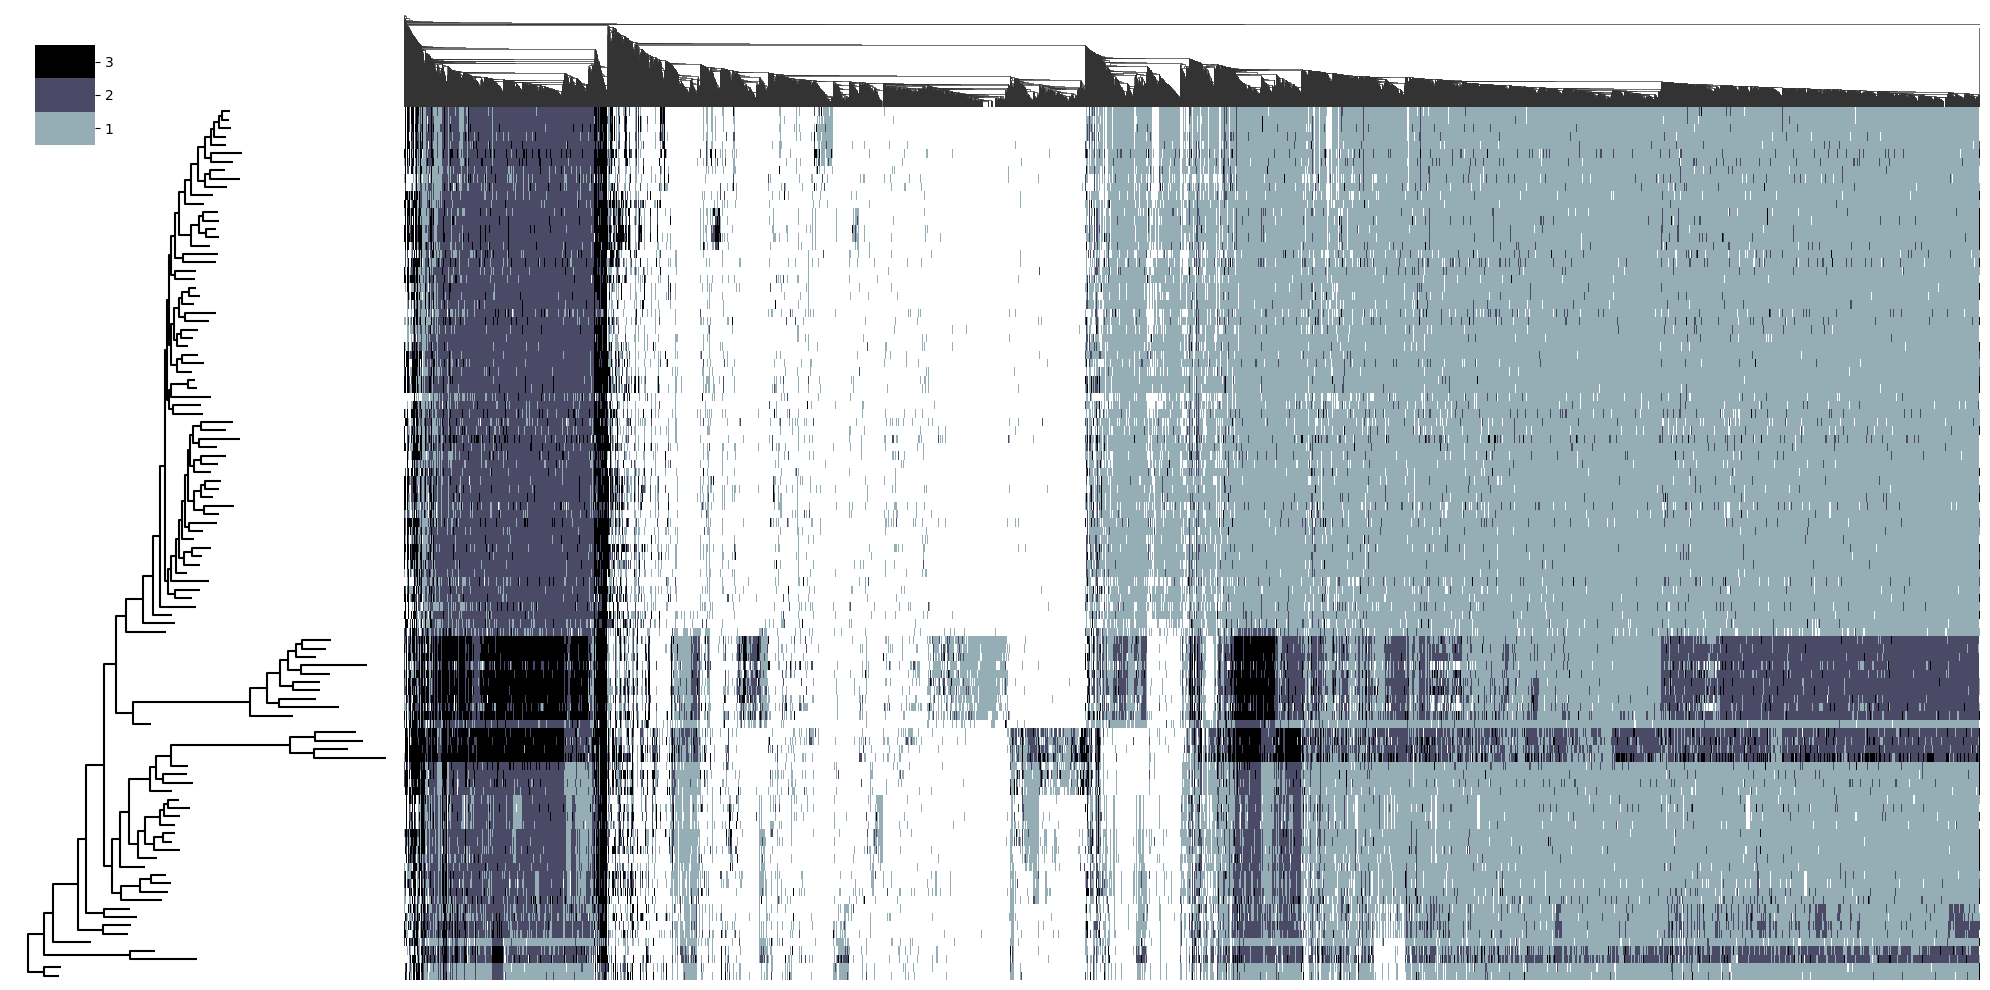

In [5]:
FOLD = 5
seed = 3488198721978

for lmax in (2, 3):
    OGs = filtOGs.clip(0, lmax)
    tindex = PostorderSerializedTree(Tree(data['tree'], format=3))
    phytbl = ExtantPhyTable(OGs.T.to_dict(orient='list'), tindex)
    
    # adjust branch length with mean MP
    phytbl.tree.branch_lengths = mean_mp_changes(phytbl).mean(axis=1)
    draw_extant(phytbl)
    
    tree_str = Tree.write(phytbl.tree.to_ete3(), format=3, format_root_node=True)
    
    rng = np.random.default_rng([lmax, seed])
    for i, test_cols in enumerate(np.array_split(rng.permutation(OGs.columns), FOLD), start=1):
        train = OGs.drop(columns=test_cols)
        test  = OGs[test_cols].sort_index(axis=1)
    
        OUT_DIR = DATASET_DIR/'03-fish'/'cv5'
        
        with gzip.open(OUT_DIR/f'fish-lmax{lmax}-train{i}-v0.json.gz', 'wt') as file:
            json.dump({
                'tree': tree_str,
                'OGs' : train.to_dict(orient='split')
            }, file, indent=2)

        with gzip.open(OUT_DIR/f'fish-lmax{lmax}-test{i}-v0.json.gz', 'wt') as file:
            json.dump({
                'tree': tree_str,
                'OGs' : test.to_dict(orient='split')
            }, file, indent=2)
    